<a href="https://colab.research.google.com/github/NizarArdansyah/Capstone-Project-Machine-Learning/blob/main/Soil%20Model/Soil_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Library**#

In [ ]:
from google.colab import drive

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

drive.mount('/content/drive/')

Mounted at /content/drive/


#**Load dataset**#

In [ ]:
base_dir = '/content/drive/My Drive/Capstone/'
!ls "/content/drive/My Drive/Capstone/"

Soil_Types  Soil_Types_Splited


#**Split dataset untuk training dan testing**#

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
soil_dir = os.path.join(base_dir, 'Soil_Types')
split_dir = os.path.join(base_dir, 'Soil_Types_Splited')
import splitfolders

splitfolders.ratio(soil_dir, output=split_dir, seed=42, ratio=(0.9,0.1), group_prefix=None)
training_dir = os.path.join(split_dir, 'train')
validation_dir = os.path.join(split_dir, 'val')

Copying files: 82 files [01:57,  1.44s/ files]


In [ ]:
geluh_dir = os.path.join(soil_dir, 'Tanah_Geluh/')
liat_dir = os.path.join(soil_dir, 'Tanah_Liat/')
aluvial_dir = os.path.join(soil_dir, 'Tanah_Aluvial/')
laterit_dir = os.path.join(soil_dir, 'Tanah_Laterit/')

print("Jumlah Data Train Tiap Kelas")
print("Jumlah gambar tanah geluh :", len(os.listdir(geluh_dir)))
print("Jumlah gambar tanah liat :", len(os.listdir(liat_dir)))
print("Jumlah gambar tanah aluvial :", len(os.listdir(aluvial_dir)))
print("Jumlah gambar tanah laterit :", len(os.listdir(laterit_dir)))

Jumlah Data Train Tiap Kelas
Jumlah gambar tanah geluh : 12
Jumlah gambar tanah liat : 29
Jumlah gambar tanah aluvial : 11
Jumlah gambar tanah laterit : 30


#**Pemrosesan gambar pada dataset**#

In [ ]:
n_batch = 32

In [ ]:
def train_val_generators(training_dir, validation_dir):

  train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)

  train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                      batch_size=n_batch,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=n_batch,
                                                                class_mode='categorical',
                                                                shuffle= False,
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 82 images belonging to 4 classes.
Found 15 images belonging to 4 classes.


#**Indexing label tanah**#

In [ ]:
for image_batch, label_batch in train_generator:
  break
  image_batch.shape, label_batch.shape

In [ ]:
print (train_generator.class_indices)

{'Tanah_Aluvial': 0, 'Tanah_Geluh': 1, 'Tanah_Laterit': 2, 'Tanah_Liat': 3}


#**Modeling CNN**#

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs = {}):
    if(logs.get('accuracy') > 0.91):
      print('Akurasi mencapai >90%')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential([
    # layer convolutional pertama
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # layer convolutional kedua
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer convolutional ketiga
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # menentukan jumlah output label
    tf.keras.layers.Dense(4, activation='softmax')
  ])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate = 0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

**Train the model**


In [ ]:
total_sample = train_generator.n
n_epochs = 30

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch = int(total_sample/n_batch),
                    verbose=1,
                    validation_data=validation_generator
                    )


Epoch 1/30
2/2 [==============================] - 25s 4s/step - loss: 1.5795 - accuracy: 0.2812 - val_loss: 1.6122 - val_accuracy: 0.2000
Epoch 2/30
2/2 [==============================] - 2s 1s/step - loss: 1.4345 - accuracy: 0.3438 - val_loss: 1.2612 - val_accuracy: 0.6000
Epoch 3/30
2/2 [==============================] - 1s 635ms/step - loss: 1.1831 - accuracy: 0.5781 - val_loss: 1.1593 - val_accuracy: 0.6000
Epoch 4/30
2/2 [==============================] - 1s 383ms/step - loss: 1.0123 - accuracy: 0.6800 - val_loss: 1.0690 - val_accuracy: 0.5333
Epoch 5/30
2/2 [==============================] - 1s 838ms/step - loss: 0.9162 - accuracy: 0.6094 - val_loss: 1.0355 - val_accuracy: 0.4667
Epoch 6/30
2/2 [==============================] - 1s 364ms/step - loss: 0.7028 - accuracy: 0.7400 - val_loss: 1.2446 - val_accuracy: 0.5333
Epoch 7/30
2/2 [==============================] - 1s 821ms/step - loss: 0.6320 - accuracy: 0.7656 - val_loss: 0.8842 - val_accuracy: 0.6000
Epoch 8/30
2/2 [=========

In [ ]:
valid_loss, valid_accuracy = model.evaluate(validation_generator)
print("Akurasi yang diperoleh: {}".format(valid_accuracy))

1/1 [==============================] - 0s 172ms/step - loss: 0.3753 - accuracy: 0.8000
Akurasi yang diperoleh: 0.800000011920929


#**Save Model**#

In [ ]:
# serialize model ke JSON
model_json = model.to_json()
with open("model_tanah.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights ke HDF5
model.save_weights("model_tanah.h5")
print("Model berhasil disimpan!")

Model berhasil disimpan!


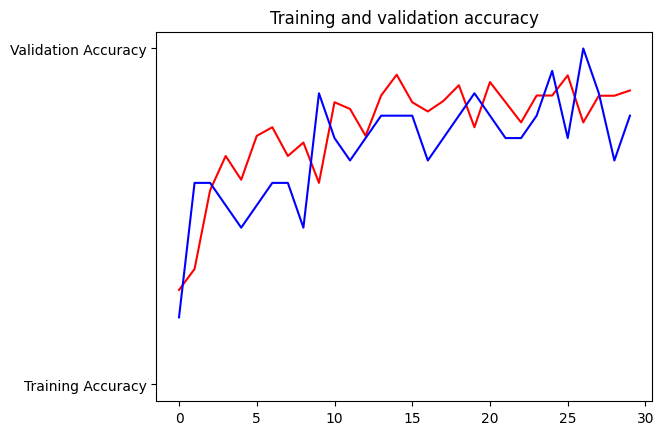

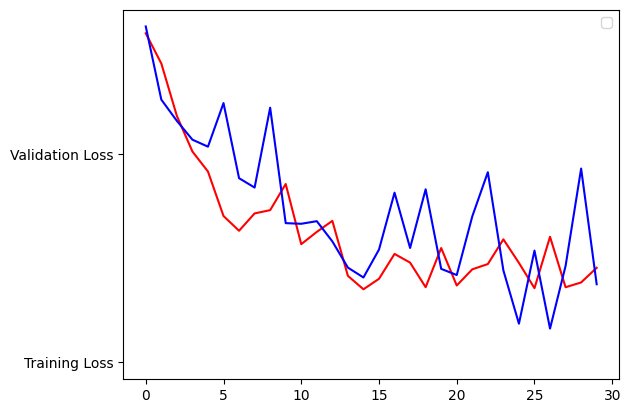

In [ ]:
# Mengambil daftar hasil list pada data training dan test
# set untuk setiap epoch pelatihan
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # nomor epoch

# Plot akurasi training dan validation per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot loss training dan validation per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend()
plt.show()

#**Penerapan Model**#

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

# load json dan buat model
json_file = open('model_tanah.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights menjadi model baru
loaded_model.load_weights("model_tanah.h5")
print("Model berhasil dimuat!")

Model berhasil dimuat!


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images, batch_size=10)

  # Mendapatkan indeks maksimum dari hasil prediksi
  predicted_label_index = np.argmax(prediction)

  # Daftar label yang sesuai dengan indeks prediksi
  labels = ['Tanah_Aluvial','Tanah_Geluh', 'Tanah Laterit','Tanah Liat']

  # Mendapatkan label prediksi
  predicted_label = labels[predicted_label_index]

  print(fn)
  print(prediction)
  print(f'Hasil prediksi tanah : {predicted_label}')

Saving tanah-liat.jpg to tanah-liat.jpg
1/1 [==============================] - 0s 496ms/step
tanah-liat.jpg
[[0. 0. 0. 1.]]
Hasil prediksi tanah : Tanah Liat
